In [1]:
import qiskit.qasm3 
from qiskit.qasm import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library.standard_gates import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_circuit_layout

In [2]:
# Your token can be found here: https://quantum-computing.ibm.com/
API_TOKEN = "?"

In [3]:
# Save account credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
# IBMProvider.save_account(token=API_TOKEN, overwrite=True)

In [4]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
provider = IBMProvider(instance="ibm-q/open/main")

In [5]:
# Use the simulator since is faster
backend = provider.get_backend("ibmq_qasm_simulator")

In [16]:
# Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
# INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (len(qc.qubits)) \
    and (x.configuration().simulator == False) and (x.status().operational))
backend = least_busy(backends)
print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  ibm_nairobi


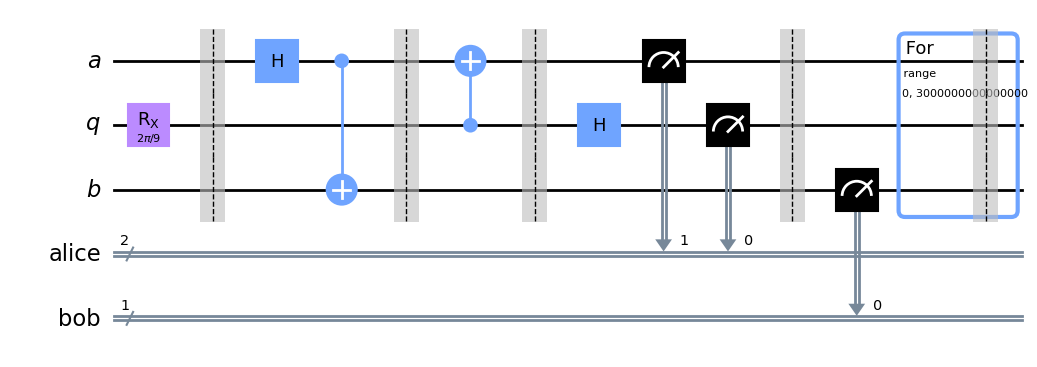

In [17]:
# Create a quantum circuit
program = """
    OPENQASM 3;
    include "stdgates.inc";

    // setup quantum and classic registry
    bit[2] alice;
    bit[1] bob;
    qubit[1] a;
    qubit[1] q;
    qubit[1] b;

    // Prepare the state of the qubit we will teleport
    rx(2*pi/9) q[0];
    
    barrier a[0], q[0], b[0];

    // Entangle Alice and Bob
    h a[0];
    cx a[0], b[0];
    
    barrier a[0], q[0], b[0];

    // Entangle Alice and Qubit
    cx q[0], a[0];
    
    barrier a[0], q[0], b[0];

    // Measure in a basis roated by appplying a hadamard gate
    h q[0];
    alice[0] = measure q[0];
    alice[1] = measure a[0];
    
    barrier a[0], q[0], b[0];
    
    // Now measure Bob's qubit to verify that the Qubit's state was teleported to Bob
    bob[0] = measure b[0];

    for int[32] i in [0:30000000000000000000000000000] {
        barrier;
    }
"""

qc = qiskit.qasm3.loads(program)

# Visualize the quantum circuit
qc.draw('mpl')

In [18]:
# Transpile the circuit in order to run on a real device
transpiled_circuit = transpile(qc, backend=backend, optimization_level=2)

OverflowError: Python int too large to convert to C ssize_t

In [37]:
# Transpile circuit and send it to a quantum device or to a simulator
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs
try:
    job = execute(transpiled_circuit, backend, shots=100)
    print(job)
except Exception as ex:
    print(ex.message)

<IBMCircuitJob('cn4ee7gvayrg008enad0')>


In [38]:
# Monitor live the job progress
job_monitor(job, interval=3)

Job Status: job has successfully run


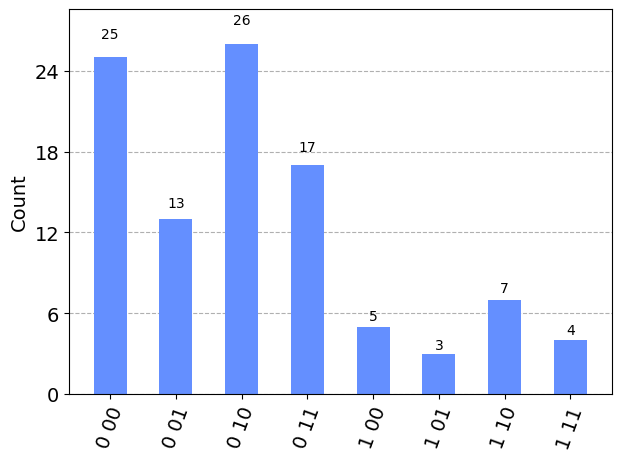

In [39]:
# Get job result
results = job.result()
# Plot job results: these are the result after aplying a quantum gate which rotates one qubit
# with angle theta. Note that the results are not symmetric, 0 state is measured more often than 1
answer = results.get_counts()
plot_histogram(answer)

In [120]:
from qiskit.tools.jupyter import *

%qiskit_version_table